Feature Selection1: FS-NCD, FS-NACD data 생성

In [556]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

# Step 1: 경로 설정
# ncds_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\Dataset\NCDS.csv"
# acds_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\Dataset\ACDS.csv"
ncds_path = r"D:\Users\user\jupyter2\ml\dataset\User1\Dataset\NCDS.csv"
acds_path = r"D:\Users\user\jupyter2\ml\dataset\User1\Dataset\ACDS.csv"

# save_dir = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\FeaturePreprocessing"
save_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\FeaturePreprocessing"
os.makedirs(save_dir, exist_ok=True)  # 폴더가 없으면 생성

# Step 2: 헤더 정의 (26개 열)
headers = [
    "Mean_GyroAccel_X", "Std_GyroAccel_X", "Mean_GyroAccel_Y", "Std_GyroAccel_Y",
    "Mean_GyroAccel_Z", "Std_GyroAccel_Z", "Mean_GyroAngular_X", "Std_GyroAngular_X",
    "Mean_GyroAngular_Y", "Std_GyroAngular_Y", "Mean_GyroAngular_Z", "Std_GyroAngular_Z",
    "Mean_Accel_X", "Std_Accel_X", "Mean_Accel_Y", "Std_Accel_Y",
    "Mean_Accel_Z", "Std_Accel_Z", "Heart_Rate", "Skin_Temp",
    "Delta_Pedometer", "Delta_Distance", "Speed", "Pace", "Delta_Calories", "UV"
]

# Step 3: 데이터 불러오기 및 전처리
ncds_data = pd.read_csv(ncds_path, header=None, names=headers)
acds_data = pd.read_csv(acds_path, header=None).iloc[:, :26]
acds_data.columns = headers

# 결측치 처리
ncds_data = ncds_data.apply(pd.to_numeric, errors='coerce').dropna()
acds_data = acds_data.apply(pd.to_numeric, errors='coerce').dropna()

# Step 4: FS-NCD와 FS-NACD 데이터셋 생성
fs_ncd = ncds_data.copy()
fs_nacd = pd.concat([ncds_data, acds_data], ignore_index=True)

# Step 5: 데이터셋 비교
if fs_ncd.equals(fs_nacd):
    print("FS-NCD와 FS-NACD가 동일합니다. 입력 데이터를 확인하세요.")
else:
    print("FS-NCD와 FS-NACD가 다릅니다. 분석을 진행하세요.")

# Step 6: 파일명 생성 (고유성 보장)
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # 타임스탬프 추가
ncds_filename = f"FS_NCD_Preprocessed.csv"
nacd_filename = f"FS_NACD_Preprocessed.csv"

# Step 7: 데이터 저장
ncds_save_path = os.path.join(save_dir, ncds_filename)
nacd_save_path = os.path.join(save_dir, nacd_filename)

fs_ncd.to_csv(ncds_save_path, index=False)
fs_nacd.to_csv(nacd_save_path, index=False)

print(f"FS-NCD 데이터셋이 저장되었습니다: {ncds_save_path}")
print(f"FS-NACD 데이터셋이 저장되었습니다: {nacd_save_path}")


Feature Selection2: 실제 feature selection

In [557]:
import pandas as pd
import numpy as np
import os
from scipy.stats import iqr, entropy

# 1. 데이터 로드 및 전처리 함수
def load_and_preprocess_data(ncds_path, acds_path, headers):
    """데이터 로드 및 전처리"""
    # NCDS 데이터 로드
    ncds_data = pd.read_csv(ncds_path, header=None, names=headers)
    
    # ACDS 데이터 로드 및 열 제한
    acds_data = pd.read_csv(acds_path, header=None).iloc[:, :26]
    acds_data.columns = headers

    # 결측치 처리
    ncds_data = ncds_data.apply(pd.to_numeric, errors='coerce').dropna()
    acds_data = acds_data.apply(pd.to_numeric, errors='coerce').dropna()

    # FS-NCD와 FS-NACD 생성
    fs_ncd = ncds_data.copy()
    fs_nacd = pd.concat([ncds_data, acds_data], ignore_index=True)

    return fs_ncd, fs_nacd

# 2. Feature Selection Methods
def calculate_information_score(data):
    """Information Score: Reduction in entropy when a feature is removed."""
    scores = []
    for col in data.columns:
        without_col = data.drop(columns=[col])
        original_values = np.abs(data.values.flatten())
        reduced_values = np.abs(without_col.values.flatten())
        original_prob = original_values / np.sum(original_values)
        reduced_prob = reduced_values / np.sum(reduced_values)
        original_entropy = entropy(original_prob)
        reduced_entropy = entropy(reduced_prob)
        scores.append(original_entropy - reduced_entropy)
    return pd.Series(scores, index=data.columns)

def calculate_pearson_correlation(data):
    """Pearson Correlation: Sum of absolute correlations with other features."""
    correlations = []
    for col in data.columns:
        corr_sum = sum(abs(data[col].corr(data[other_col])) for other_col in data.columns if col != other_col)
        correlations.append(corr_sum)
    return pd.Series(correlations, index=data.columns)

def calculate_intra_class_distance(data):
    """Intra-Class Distance: Average distance to feature centroids."""
    scores = []
    for col in data.columns:
        centroid = data[col].mean()
        distances = np.abs(data[col] - centroid)
        scores.append(distances.mean())
    return pd.Series(scores, index=data.columns)

def calculate_interquartile_range(data):
    """Interquartile Range (IQR): Measure of dispersion."""
    return pd.Series(iqr(data, axis=0), index=data.columns)

# 3. Feature Selection Execution
def feature_selection(data, method_name):
    """Execute feature selection for a given method."""
    if method_name == "IS":
        return calculate_information_score(data)
    elif method_name == "PC":
        return calculate_pearson_correlation(data)
    elif method_name == "ICD":
        return calculate_intra_class_distance(data)
    elif method_name == "IQR":
        return calculate_interquartile_range(data)
    else:
        raise ValueError("Unknown method name.")

# 4. Feature Selection 실행 및 결과 저장
def execute_feature_selection(fs_ncd, fs_nacd, methods, save_dir):
    """FS-NCD 및 FS-NACD에 대한 Feature Selection 실행."""
    results_ncd = {}
    results_nacd = {}

    for method in methods:
        results_ncd[method] = feature_selection(fs_ncd, method)
        results_nacd[method] = feature_selection(fs_nacd, method)

    # Combine Results into DataFrames
    fs_ncd_results = pd.DataFrame(results_ncd)
    fs_nacd_results = pd.DataFrame(results_nacd)

    # Add rank columns for each method
    for method in methods:
        ascending = True if method in ["IQR"] else False  # IQR은 오름차순으로 정렬
        fs_ncd_results[f"{method}_Rank"] = fs_ncd_results[method].rank(ascending=ascending)
        fs_nacd_results[f"{method}_Rank"] = fs_nacd_results[method].rank(ascending=ascending)

    # 저장 경로 폴더 생성
    os.makedirs(save_dir, exist_ok=True)
    fs_ncd_results.to_csv(os.path.join(save_dir, "FS_NCD_Results.csv"), index=True)
    fs_nacd_results.to_csv(os.path.join(save_dir, "FS_NACD_Results.csv"), index=True)

    print("Feature Selection completed and saved.")

# 5. 실행
if __name__ == "__main__":
    # 헤더 정보
    headers = [
        "Mean_GyroAccel_X", "Std_GyroAccel_X", "Mean_GyroAccel_Y", "Std_GyroAccel_Y",
        "Mean_GyroAccel_Z", "Std_GyroAccel_Z", "Mean_GyroAngular_X", "Std_GyroAngular_X",
        "Mean_GyroAngular_Y", "Std_GyroAngular_Y", "Mean_GyroAngular_Z", "Std_GyroAngular_Z",
        "Mean_Accel_X", "Std_Accel_X", "Mean_Accel_Y", "Std_Accel_Y",
        "Mean_Accel_Z", "Std_Accel_Z", "Heart_Rate", "Skin_Temp",
        "Delta_Pedometer", "Delta_Distance", "Speed", "Pace", "Delta_Calories", "UV"
    ]

    # 데이터 경로
    # ncds_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\Dataset\NCDS.csv"
    # acds_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\Dataset\ACDS.csv"
    # save_dir = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\Feature_selection"
    ncds_path = r"D:\Users\user\jupyter2\ml\dataset\User1\Dataset\NCDS.csv"
    acds_path = r"D:\Users\user\jupyter2\ml\dataset\User1\Dataset\ACDS.csv"
    save_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_selection"
    
    # 데이터 로드 및 전처리
    fs_ncd, fs_nacd = load_and_preprocess_data(ncds_path, acds_path, headers)

    # Feature Selection 실행
    methods = ["IS", "PC", "ICD", "IQR"]
    execute_feature_selection(fs_ncd, fs_nacd, methods, save_dir)


Feature Selection3: aggregation

In [558]:
import pandas as pd
import numpy as np
import os

# Feature Selection Aggregation Methods
def mean_aggregation(fs_results):
    """Mean Aggregation: 평균 순위를 계산."""
    aggregated_ranks = fs_results[[col for col in fs_results.columns if '_Rank' in col]].mean(axis=1)
    return aggregated_ranks

def median_aggregation(fs_results):
    """Median Aggregation: 중앙값 순위를 계산."""
    aggregated_ranks = fs_results[[col for col in fs_results.columns if '_Rank' in col]].median(axis=1)
    return aggregated_ranks

def majority_voting(fs_results):
    """Majority Voting: 최빈값으로 결정."""
    majority_votes = []
    for _, row in fs_results[[col for col in fs_results.columns if '_Rank' in col]].iterrows():
        mode = row.mode()  # 최빈값 계산
        if len(mode) == 1:
            majority_votes.append(mode.iloc[0])  # 하나의 최빈값일 경우
        else:
            # 최빈값이 여러 개인 경우우
            # majority_votes.append(np.nan)         # 공란
            # majority_votes.append(mode.median())  # 중앙
            majority_votes.append(mode.mean())      # 평균
    return pd.Series(majority_votes, index=fs_results.index)

def borda_count(fs_results):
    """Borda Count: 순위에 점수를 부여하고 합산."""
    borda_scores = pd.Series(0, index=fs_results.index)
    for col in fs_results.columns:
        if '_Rank' in col:
            max_rank = len(fs_results)
            borda_scores += max_rank - fs_results[col]  # 높은 순위에 더 많은 점수 부여
    return borda_scores

# Aggregation Execution
def perform_aggregation(fs_results):
    """Aggregation 수행."""
    print("Performing Aggregation...")

    # Mean Aggregation
    fs_results['Mean_Aggregation'] = mean_aggregation(fs_results)

    # Median Aggregation
    fs_results['Median_Aggregation'] = median_aggregation(fs_results)

    # Majority Voting
    fs_results['Majority_Voting'] = majority_voting(fs_results)

    # Borda Count
    fs_results['Borda_Count'] = borda_count(fs_results)

    return fs_results

# 저장 경로 설정
# load_dir = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\Feature_selection"  # 원본 파일 경로
# save_dir = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\Feature_aggregation"  # 결과 저장 경로
load_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_selection"  # 원본 파일 경로
save_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation"  # 결과 저장 경로
os.makedirs(save_dir, exist_ok=True)  # 폴더 생성

# Load Feature Selection Results for FS-NCD and FS-NACD
fs_ncd_results = pd.read_csv(os.path.join(load_dir, "FS_NCD_Results.csv"), index_col=0)  # NCD 데이터
fs_nacd_results = pd.read_csv(os.path.join(load_dir, "FS_NACD_Results.csv"), index_col=0)  # NACD 데이터

# Perform Aggregation for FS-NCD
print("Aggregating FS-NCD...")
fs_ncd_results = perform_aggregation(fs_ncd_results)
ncd_save_path = os.path.join(save_dir, "FS_NCD_Aggregated_Results.csv")
fs_ncd_results.to_csv(ncd_save_path)

# Perform Aggregation for FS-NACD
print("Aggregating FS-NACD...")
fs_nacd_results = perform_aggregation(fs_nacd_results)
nacd_save_path = os.path.join(save_dir, "FS_NACD_Aggregated_Results.csv")
fs_nacd_results.to_csv(nacd_save_path)

print(f"Aggregation completed and saved for FS-NCD: {ncd_save_path}")
print(f"Aggregation completed and saved for FS-NACD: {nacd_save_path}")


속성 가중치 기반 샘플링(projection)
1. 현재는 Median_Aggregation 만 지정되어 있음
- 이 외에도 Mean_Aggregation, Borda_Count 속성에 대해서도 실행해야 함.
2.  속성 수 설정 현재는 10개로 되어 있음
- 26개에서 1개씩 빼면서 계속 projection 해야 함 
3. 속성 가중치 종류와 속성 수를 반영한 projection 데이터셋을 Feature Projection 폴더 안에 저장함. 

In [ ]:
####### 원본 ##########
import pandas as pd
import numpy as np
import os
global best_features_ncd
# 가중치 기반 속성 샘플링 함수
def weighted_attribute_sampling(weights, num_attributes):
    """
    속성 가중치를 기반으로 속성을 무작위로 샘플링합니다.

    Parameters:
        weights (list): 속성 중요도 가중치 리스트.
        num_attributes (int): 선택할 속성의 수.

    Returns:
        list: 선택된 속성 인덱스.
    """
    normalized_weights = np.array(weights) / sum(weights)  # 가중치 정규화
    sampled_features = np.random.choice(
        len(weights), size=num_attributes, replace=False, p=normalized_weights
    )
    return sampled_features

# 가중치 데이터 로드
# fs_ncd_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\Feature_aggregation\FS_NCD_Aggregated_Results.csv"
# fs_nacd_path = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\feature_selection\Feature_aggregation\FS_NACD_Aggregated_Results.csv"
fs_ncd_path = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation\FS_NCD_Aggregated_Results.csv"
fs_nacd_path = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation\FS_NACD_Aggregated_Results.csv"

fs_ncd = pd.read_csv(fs_ncd_path)
fs_nacd = pd.read_csv(fs_nacd_path)

# 가중치 열 선택
weights_column = "Median_Aggregation"  # 가중치 컬럼 이름
weights_ncd = fs_ncd[weights_column].values
weights_nacd = fs_nacd[weights_column].values

# 속성 수 설정 (예: 10개 속성 선택)
num_attributes = 10

# 헤더 정보 추가
headers = [
    "Mean_GyroAccel_X", "Std_GyroAccel_X", "Mean_GyroAccel_Y", "Std_GyroAccel_Y",
    "Mean_GyroAccel_Z", "Std_GyroAccel_Z", "Mean_GyroAngular_X", "Std_GyroAngular_X",
    "Mean_GyroAngular_Y", "Std_GyroAngular_Y", "Mean_GyroAngular_Z", "Std_GyroAngular_Z",
    "Mean_Accel_X", "Std_Accel_X", "Mean_Accel_Y", "Std_Accel_Y",
    "Mean_Accel_Z", "Std_Accel_Z", "Heart_Rate", "Skin_Temp",
    "Delta_Pedometer", "Delta_Distance", "Speed", "Pace", "Delta_Calories", "UV"
]

# Fold 경로 설정
# fold_base_dir = r"D:\Users\user\Desktop\DL 프로젝트\DATA\User1\User1\FiveFoldCrossValidation"
fold_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation"

# 각 Fold에 대해 속성 투영 수행
for fold in range(1, 6):  # Fold1 ~ Fold5
    print(f"Processing Fold {fold}...")

    # 파일 경로 설정
    training_file = os.path.join(fold_base_dir, f"Fold{fold}", "training.csv")
    projection_dir = os.path.join(fold_base_dir, f"Fold{fold}", "projection")
    os.makedirs(projection_dir, exist_ok=True)  # projection 폴더 생성

    # 데이터 로드 (헤더 추가)
    training_df = pd.read_csv(training_file, header=None, names=headers)
    
    # 속성 투영 수행
    selected_features_ncd = weighted_attribute_sampling(weights_ncd, num_attributes)
    selected_features_nacd = weighted_attribute_sampling(weights_nacd, num_attributes)
    
    # 선택된 속성 인덱스를 헤더에 매칭
    selected_columns_ncd = [headers[i] for i in selected_features_ncd]
    selected_columns_nacd = [headers[i] for i in selected_features_nacd]
    
    projected_ncds = training_df[selected_columns_ncd]
    projected_acds = training_df[selected_columns_nacd]
    
    # 파일명 생성 및 저장 (헤더 포함)
    ncds_save_path = os.path.join(projection_dir, f"{weights_column}_num_attribute{num_attributes}_Projected_NCDS.csv")
    acds_save_path = os.path.join(projection_dir, f"{weights_column}_num_attribute{num_attributes}_Projected_ACDS.csv")
    
    projected_ncds.to_csv(ncds_save_path, index=False)
    projected_acds.to_csv(acds_save_path, index=False)
    
    print(f"Fold {fold} - NCDS 데이터셋 저장됨: {ncds_save_path}")
    print(f"Fold {fold} - ACDS 데이터셋 저장됨: {acds_save_path}")

print("모든 Fold에 대해 속성 투영이 완료되었습니다.")


Processing Fold 1...
Fold 1 - NCDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold1\projection\Median_Aggregation_num_attribute26_Projected_NCDS.csv
Fold 1 - ACDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold1\projection\Median_Aggregation_num_attribute26_Projected_ACDS.csv
Processing Fold 2...
Fold 2 - NCDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold2\projection\Median_Aggregation_num_attribute26_Projected_NCDS.csv
Fold 2 - ACDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold2\projection\Median_Aggregation_num_attribute26_Projected_ACDS.csv
Processing Fold 3...
Fold 3 - NCDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold3\projection\Median_Aggregation_num_attribute26_Projected_NCDS.csv
Fold 3 - ACDS 데이터셋 저장됨: D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation\Fold3\projection\Median_Aggregation_num_attribute26_Pr

In [ ]:
### 앙상블 적용 ###
import pandas as pd
import numpy as np
import os

# 가중치 기반 속성 샘플링 함수
def weighted_attribute_sampling(weights, num_attributes):
    """
    속성 가중치를 기반으로 속성을 무작위로 샘플링합니다.

    Parameters:
        weights (list or np.ndarray): 속성 중요도 가중치 리스트/배열
        num_attributes (int): 선택할 속성의 수

    Returns:
        np.ndarray: 선택된 속성 인덱스
    """
    normalized_weights = np.array(weights) / np.sum(weights)  # 가중치 정규화
    sampled_features = np.random.choice(
        len(weights), size=num_attributes, replace=False, p=normalized_weights
    )
    return sampled_features

# [1] 가중치 데이터 로드
fs_ncd_path = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation\FS_NCD_Aggregated_Results.csv"
fs_nacd_path = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation\FS_NACD_Aggregated_Results.csv"

fs_ncd = pd.read_csv(fs_ncd_path)
fs_nacd = pd.read_csv(fs_nacd_path)

# [2] 가중치 열(컬럼) 리스트 설정
weights_column_list = ["Median_Aggregation", "Mean_Aggregation", "Majority_Voting", "Borda_Count"]

# [3] 속성 수 리스트로 설정
num_attributes_list = [26, 24, 22, 20, 18, 16, 14, 12, 10]

# [4] 헤더 정보
headers = [
    "Mean_GyroAccel_X", "Std_GyroAccel_X", "Mean_GyroAccel_Y", "Std_GyroAccel_Y",
    "Mean_GyroAccel_Z", "Std_GyroAccel_Z", "Mean_GyroAngular_X", "Std_GyroAngular_X",
    "Mean_GyroAngular_Y", "Std_GyroAngular_Y", "Mean_GyroAngular_Z", "Std_GyroAngular_Z",
    "Mean_Accel_X", "Std_Accel_X", "Mean_Accel_Y", "Std_Accel_Y",
    "Mean_Accel_Z", "Std_Accel_Z", "Heart_Rate", "Skin_Temp",
    "Delta_Pedometer", "Delta_Distance", "Speed", "Pace", "Delta_Calories", "UV"
]

# [5] Fold 경로 설정
fold_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation"

# [6] Fold별로, weights_column별로, num_attributes별로 반복
for fold in range(1, 6):  # Fold1 ~ Fold5
    print(f"Processing Fold {fold}...")

    # 파일 경로 설정
    training_file = os.path.join(fold_base_dir, f"Fold{fold}", "training.csv")
    projection_dir = os.path.join(fold_base_dir, f"Fold{fold}", "projection")
    os.makedirs(projection_dir, exist_ok=True)  # projection 폴더 생성

    # 데이터 로드 (헤더 추가)
    training_df = pd.read_csv(training_file, header=None, names=headers)

    # (1) weights_column_list 루프
    for w_col in weights_column_list:
        # NCD와 NACD에서 각각 해당 컬럼의 가중치 추출
        weights_ncd = fs_ncd[w_col].values
        weights_nacd = fs_nacd[w_col].values

        # (2) num_attributes_list 루프
        for num_attributes in num_attributes_list:
            # [A] 앙상블 속성 투영 (50번 반복 후 가장 많이 선택된 속성 선택)
            ensemble_size = 50
            feature_counts_ncd = np.zeros(len(weights_ncd))
            feature_counts_nacd = np.zeros(len(weights_nacd))

            for _ in range(ensemble_size):
                sampled_ncd = weighted_attribute_sampling(weights_ncd, num_attributes)
                sampled_nacd = weighted_attribute_sampling(weights_nacd, num_attributes)
                
                # 선택된 속성 카운트 증가
                feature_counts_ncd[sampled_ncd] += 1
                feature_counts_nacd[sampled_nacd] += 1

            # 가장 많이 선택된 속성 추출
            selected_features_ncd = np.argsort(feature_counts_ncd)[-num_attributes:]
            selected_features_nacd = np.argsort(feature_counts_nacd)[-num_attributes:]

            # [B] 선택된 속성 인덱스를 헤더에 매칭
            selected_columns_ncd = [headers[i] for i in selected_features_ncd]
            selected_columns_nacd = [headers[i] for i in selected_features_nacd]

            # [C] 선택된 속성으로 투영
            projected_ncds = training_df[selected_columns_ncd]
            projected_acds = training_df[selected_columns_nacd]

            # [D] 파일명 생성 및 저장 (헤더 포함)
            ncds_save_path = os.path.join(
                projection_dir, f"{w_col}_num_attribute{num_attributes}_Projected_NCDS.csv"
            )
            acds_save_path = os.path.join(
                projection_dir, f"{w_col}_num_attribute{num_attributes}_Projected_ACDS.csv"
            )

            projected_ncds.to_csv(ncds_save_path, index=False)
            projected_acds.to_csv(acds_save_path, index=False)

            print(f"  [Fold {fold}] w_col = '{w_col}', num_attributes = {num_attributes}")
            print(f"    -> NCDS 저장: {ncds_save_path}")
            print(f"    -> ACDS 저장: {acds_save_path}")

print("모든 Fold에 대해 속성 투영이 완료되었습니다.")


대표 객체 선택(MROs)

In [ ]:
import pandas as pd
import numpy as np
import os

# 대표 객체(MROs) 선택 함수
def select_mros(data, sampling_fraction, mros_percentage, random_state=42):
    """
    RandomMiner 알고리즘을 사용하여 대표 객체(MROs)를 선택합니다.
    
    Parameters:
        data (DataFrame): 투영된 데이터셋.
        sampling_fraction (float): 부트스트랩 샘플링 비율.
        mros_percentage (float): 대표 객체 비율.
        random_state (int): 무작위 시드 설정.

    Returns:
        DataFrame: 선택된 대표 객체(MROs).
    """
    # Step 1: 부트스트랩 샘플링
    bootstrap_sample = data.sample(frac=sampling_fraction, replace=True, random_state=random_state)
    
    # Step 2: 대표 객체 선택
    num_mros = max(1, int(len(bootstrap_sample) * mros_percentage))  # 최소 1개 이상
    mros = bootstrap_sample.sample(n=num_mros, random_state=random_state)
    
    return mros


# 경로 설정
fold_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation"
mros_save_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\MROs"

os.makedirs(mros_save_base_dir, exist_ok=True)  # MROs 저장 폴더 생성

# 조건 리스트 설정
weights_column_list = ["Median_Aggregation", "Mean_Aggregation", "Majority_Voting", "Borda_Count"]
num_attributes_list = [26, 24, 22, 20, 18, 16, 14, 12, 10]
sampling_fraction_list = [0.1, 0.2, 0.3, 0.4, 0.5]  # 샘플링 비율 리스트
mros_percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5]   # 대표 객체 비율 리스트

# 각 Fold에서 MROs 생성 및 저장
for fold in range(1, 6):  # Fold1 ~ Fold5
    print(f"Processing Fold {fold}...")
    
    # 파일 경로 설정
    projection_dir = os.path.join(fold_base_dir, f"Fold{fold}", "projection")
    
    # 조건에 따라 파일 처리
    for weights_column in weights_column_list:
        for num_attributes in num_attributes_list:
            for sampling_fraction in sampling_fraction_list:
                for mros_percentage in mros_percentage_list:
                    # 파일명 설정
                    ncds_file_name = f"{weights_column}_num_attribute{num_attributes}_Projected_NCDS.csv"
                    acds_file_name = f"{weights_column}_num_attribute{num_attributes}_Projected_ACDS.csv"
                    
                    # 파일 경로 설정
                    projected_ncds_file = os.path.join(projection_dir, ncds_file_name)
                    projected_acds_file = os.path.join(projection_dir, acds_file_name)
                    
                    # 데이터 불러오기
                    if not os.path.exists(projected_ncds_file) or not os.path.exists(projected_acds_file):
                        print(f"파일이 존재하지 않습니다: {projected_ncds_file} 또는 {projected_acds_file}")
                        continue  # 파일이 없으면 스킵
                    
                    projected_ncds = pd.read_csv(projected_ncds_file)
                    projected_acds = pd.read_csv(projected_acds_file)
                    
                    # MROs 생성
                    mros_ncds = select_mros(projected_ncds, sampling_fraction, mros_percentage)
                    mros_acds = select_mros(projected_acds, sampling_fraction, mros_percentage)
                    
                    # 저장 경로 설정
                    fold_save_dir = os.path.join(mros_save_base_dir, f"Fold{fold}")
                    os.makedirs(fold_save_dir, exist_ok=True)
                    
                    # 파일명에 조건 추가
                    ncds_save_path = os.path.join(
                        fold_save_dir, f"MROs_F{sampling_fraction}_RS{mros_percentage}_NCDS_{weights_column}_{num_attributes}.csv"
                    )
                    acds_save_path = os.path.join(
                        fold_save_dir, f"MROs_F{sampling_fraction}_RS{mros_percentage}_ACDS_{weights_column}_{num_attributes}.csv"
                    )
                    
                    # MROs 저장
                    mros_ncds.to_csv(ncds_save_path, index=False)
                    mros_acds.to_csv(acds_save_path, index=False)
                    
                    print(f"Fold {fold} - NCDS MROs 저장됨: {ncds_save_path}")
                    print(f"Fold {fold} - ACDS MROs 저장됨: {acds_save_path}")

print("모든 Fold에 대해 대표 객체(MROs) 생성 및 저장이 완료되었습니다.")


Chebyshev 거리 계산()

In [565]:
import pandas as pd
import numpy as np
import os
from numba import jit, prange, float32

@jit(float32[:](float32[:,:], float32[:,:], float32), nopython=True, parallel=True)
# 체비쇼프 거리 계산
def calculate_chebyshev_batch(test_data, mros, delta):
    n_test = test_data.shape[0]
    similarities = np.zeros(n_test, dtype=np.float32)
    
    for i in prange(n_test):
        distances = np.zeros(len(mros), dtype=np.float32)
        for j in range(len(mros)):
            distances[j] = np.max(np.abs(test_data[i] - mros[j]))
        d_min = np.min(distances)
        similarities[i] = np.exp(-(d_min ** 2) / (2 * (delta ** 2)))
    
    return similarities

# 동적 임계치 계산 함수
def calculate_dynamic_threshold(file_path, top_n, weights_column):
    """
    동적 임계치 계산 함수
    Parameters:
        file_path (str): Feature aggregation CSV 파일 경로
        top_n (int): 선택할 상위 속성 수
        weights_column (str): 사용할 가중치 컬럼 이름
    Returns:
        float: 동적 임계치 값
    """
    data = pd.read_csv(file_path)
    top_attributes = data.nsmallest(top_n, weights_column)
    weights_columns = ['IS', 'PC', 'ICD', 'IQR']
    top_weights = top_attributes[weights_columns]
    return top_weights.sum().sum()

# 경로 설정
feature_aggregation_path = r"D:\Users\user\jupyter2\ml\dataset\User1\feature_selection\Feature_aggregation\FS_NACD_Aggregated_Results.csv"
fold_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FiveFoldCrossValidation"
mros_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\MROs"
output_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\SimilarityResults"

os.makedirs(output_base_dir, exist_ok=True)

# 리스트 설정
weights_column_list = ["Median_Aggregation", "Mean_Aggregation", "Majority_Voting", "Borda_Count"]
num_attributes_list = [26, 24, 22, 20, 18, 16, 14, 12, 10]
sampling_fraction_list = [0.1, 0.2, 0.3, 0.4, 0.5]
mros_percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5]

headers = [
    "Mean_GyroAccel_X", "Std_GyroAccel_X", "Mean_GyroAccel_Y", "Std_GyroAccel_Y",
    "Mean_GyroAccel_Z", "Std_GyroAccel_Z", "Mean_GyroAngular_X", "Std_GyroAngular_X",
    "Mean_GyroAngular_Y", "Std_GyroAngular_Y", "Mean_GyroAngular_Z", "Std_GyroAngular_Z",
    "Mean_Accel_X", "Std_Accel_X", "Mean_Accel_Y", "Std_Accel_Y",
    "Mean_Accel_Z", "Std_Accel_Z", "Heart_Rate", "Skin_Temp",
    "Delta_Pedometer", "Delta_Distance", "Speed", "Pace", "Delta_Calories", "UV", "Label"
]

# k-폴드 루프
for fold in range(1, 6):
    print(f"Processing Fold {fold}...")
    
    test_data_path = os.path.join(fold_base_dir, f"Fold{fold}", "testing.csv")
    test_data = pd.read_csv(test_data_path, header=None, names=headers)

    # 숫자형 데이터 변환
    numeric_columns = test_data.select_dtypes(include=[np.number]).columns
    test_data[numeric_columns] = test_data[numeric_columns].astype(np.float32)

    label_column = test_data['Label']
    test_data_features = test_data.drop(columns=['Label'])
    
    # 리스트 조합 루프
    for weights_column in weights_column_list:
        for num_attributes in num_attributes_list:
            # 동적 임계치 계산
            calculated_delta = np.float32(calculate_dynamic_threshold(feature_aggregation_path, num_attributes, weights_column))

            for sampling_fraction in sampling_fraction_list:
                for mros_percentage in mros_percentage_list:
                    # MROs 파일 경로 설정
                    mros_file_name = f"MROs_F{sampling_fraction}_RS{mros_percentage}_ACDS_{weights_column}_{num_attributes}.csv"
                    mros_ncds_path = os.path.join(mros_base_dir, f"Fold{fold}", mros_file_name)

                    if not os.path.exists(mros_ncds_path):
                        print(f"MROs 파일이 존재하지 않습니다: {mros_ncds_path}")
                        continue

                    # MROs 데이터 로드
                    mros_ncds = pd.read_csv(mros_ncds_path)
                    numeric_columns_mros = mros_ncds.select_dtypes(include=[np.number]).columns
                    mros_ncds[numeric_columns_mros] = mros_ncds[numeric_columns_mros].astype(np.float32)

                    test_data_ncds = test_data_features[mros_ncds.columns]
                    test_data_np = test_data_ncds.values.astype(np.float32)
                    mros_np = mros_ncds.values.astype(np.float32)

                    # 유사도 계산
                    similarities_ncds = calculate_chebyshev_batch(test_data_np, mros_np, calculated_delta)

                    # 결과 저장
                    result_file_name = f"Fold{fold}_Similarity_Results_F{sampling_fraction}_RS{mros_percentage}_ACDS_{weights_column}_{num_attributes}.csv"
                    output_path = os.path.join(output_base_dir, result_file_name)
                    result_df = pd.DataFrame({
                        'Similarity_NCDS': similarities_ncds,
                        'Label': label_column
                    })
                    result_df.to_csv(output_path, index=False)

                    print(f"Fold {fold} - Results saved to: {output_path}")

print("All calculations completed successfully!")


앙상블 생성

In [ ]:
### 폴드별 유사도계산 결과 평균연산 ###
import pandas as pd
import os

# 경로 설정
fold_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\SimilarityResults_"
output_base_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FinalResults_"
os.makedirs(output_base_dir, exist_ok=True)

# 리스트 설정
weights_column_list = ["Median_Aggregation", "Mean_Aggregation", "Majority_Voting", "Borda_Count"]
num_attributes_list = [26, 24, 22, 20, 18, 16, 14, 12, 10]
sampling_fraction_list = [0.1, 0.2, 0.3, 0.4, 0.5]
mros_percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5]

# 모든 조합에 대해 평균 계산
for weights_column in weights_column_list:
    for num_attributes in num_attributes_list:
        for sampling_fraction in sampling_fraction_list:
            for mros_percentage in mros_percentage_list:

                # 파일 그룹화
                similarity_sum = None
                count = 0

                for fold in range(1, 6):
                    file_name = f"Fold{fold}_Similarity_Results_F{sampling_fraction}_RS{mros_percentage}_ACDS_{weights_column}_{num_attributes}.csv"
                    file_path = os.path.join(fold_base_dir, file_name)

                    if not os.path.exists(file_path):
                        print(f"파일이 존재하지 않습니다: {file_path}")
                        continue

                    # 데이터 로드
                    fold_data = pd.read_csv(file_path)

                    # 유사도 값 합산
                    if similarity_sum is None:
                        similarity_sum = fold_data.copy()
                        similarity_sum.rename(columns={'Similarity_NCDS': 'Similarity_Sum'}, inplace=True)
                        similarity_sum['Count'] = 1
                    else:
                        similarity_sum['Similarity_Sum'] += fold_data['Similarity_NCDS']
                        similarity_sum['Count'] += 1

                # 평균 계산
                if similarity_sum is not None:
                    similarity_sum['Average_Similarity'] = similarity_sum['Similarity_Sum'] / similarity_sum['Count']
                    result_data = similarity_sum[['Label', 'Average_Similarity']]

                    # 결과 저장
                    output_file_name = f"Average_Similarity_F{sampling_fraction}_RS{mros_percentage}_ACDS_{weights_column}_{num_attributes}.csv"
                    output_path = os.path.join(output_base_dir, output_file_name)
                    result_data.to_csv(output_path, index=False)
                    print(f"결과 저장됨: {output_path}")

print("모든 평균 계산이 완료되었습니다!")


성능 평가

[1/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_10.csv
[2/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_12.csv
[3/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_14.csv
[4/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_16.csv
[5/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_18.csv
[6/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_20.csv
[7/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_22.csv
[8/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_24.csv
[9/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Borda_Count_26.csv
[10/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Majority_Voting_10.csv
[11/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Majority_Voting_12.csv
[12/900] Processing file: Average_Similarity_F0.1_RS0.1_ACDS_Majority_Voting_14.csv
[13/900] Processing file: Average_Sim

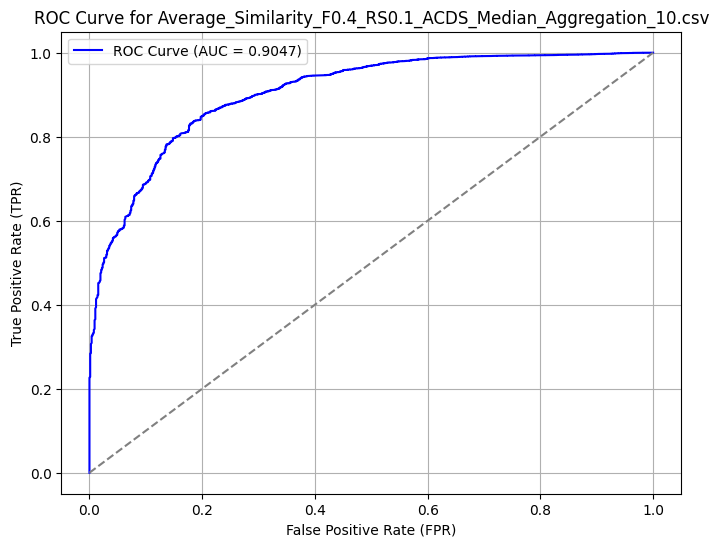

In [635]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import re

# 데이터 디렉토리 설정
data_dir = r"D:\Users\user\jupyter2\ml\dataset\User1\FinalResults_"

# 결과 저장을 위한 빈 데이터프레임 생성
results_list = []  # 데이터를 임시로 저장할 리스트

# 디렉토리 내 모든 CSV 파일 처리
file_list = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
total_files = len(file_list)

for idx, filename in enumerate(file_list, start=1):
    filepath = os.path.join(data_dir, filename)
    
    # 진행 상황 출력
    print(f"[{idx}/{total_files}] Processing file: {filename}")
    
    # 파일명에서 속성값 추출
    match = re.match(r"Average_Similarity_F(\d+\.\d+)_RS(\d+\.\d+)_ACDS_([\w_]+)_(\d+)\.csv", filename)
    if not match:
        print(f"Warning: Filename format does not match for file: {filename}")
        continue
    
    sampling_fraction, mros_percentage, weights_column, num_attributes = match.groups()

    # CSV 파일 읽기
    final_results = pd.read_csv(filepath)
    
    # 결측값 확인 및 처리
    if final_results[['Label', 'Average_Similarity']].isna().any().any():
        print(f"Warning: NaN values detected in file: {filename}. Removing rows with NaN values.")
        final_results = final_results.dropna(subset=['Label', 'Average_Similarity'])

    # 정답 라벨과 예측값 설정
    y_true = final_results['Label'].apply(lambda x: 1 if x == 'typical' else 0)
    y_scores = final_results['Average_Similarity']

    # 임계값(Threshold) 설정: 0.5 기준으로 typical/atypical 예측
    y_pred = (y_scores >= 0.5).astype(int)

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    # 결과 저장
    results_list.append({
        "Filename": filename,  # 원래 파일명
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Sampling_Fraction": float(sampling_fraction),
        "MROS_Percentage": float(mros_percentage),
        "Weights_Column": weights_column,
        "Num_Attributes": int(num_attributes)
    })

# 리스트를 DataFrame으로 변환
results_df = pd.DataFrame(results_list)

# 결과를 CSV 파일로 저장
output_path = r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv"
results_df.to_csv(output_path, index=False)

# AUC가 가장 높은 파일 찾기
best_result = results_df.loc[results_df['AUC'].idxmax()]
best_file_path = os.path.join(data_dir, best_result['Filename'])

print(f"AUC가 가장 높은 파일: {best_result['Filename']}")
print(f"해당 파일의 AUC: {best_result['AUC']}")

# AUC가 가장 높은 파일로 ROC Curve 시각화
final_results = pd.read_csv(best_file_path)

# 결측값 확인 및 제거 (y_true, y_scores)
if final_results[['Label', 'Average_Similarity']].isna().any().any():
    print(f"Warning: NaN values detected in the best file: {best_result['Filename']}. Removing rows with NaN values.")
    final_results = final_results.dropna(subset=['Label', 'Average_Similarity'])

y_true = final_results['Label'].apply(lambda x: 1 if x == 'typical' else 0)
y_scores = final_results['Average_Similarity']

# ROC Curve 및 AUC 계산
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random 예측선
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"ROC Curve for {best_result['Filename']}")
plt.legend()
plt.grid()
plt.show()



In [588]:
#### Friedman 검증 ####
from scipy.stats import friedmanchisquare
import pandas as pd

# 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 각 열(Sampling_Fraction, MROS_Percentage, Weights_Column, Num_Attributes)에 대한 Friedman Test 수행
# Sampling_Fraction에 대한 그룹 생성 및 Friedman Test 수행
sampling_fraction_groups = data.groupby('Sampling_Fraction')['AUC'].apply(list)
stat_sampling_fraction, p_sampling_fraction = friedmanchisquare(*sampling_fraction_groups)

# MROS_Percentage에 대한 그룹 생성 및 Friedman Test 수행
mros_percentage_groups = data.groupby('MROS_Percentage')['AUC'].apply(list)
stat_mros_percentage, p_mros_percentage = friedmanchisquare(*mros_percentage_groups)

# Weights_Column에 대한 그룹 생성 및 Friedman Test 수행
weights_column_groups = data.groupby('Weights_Column')['AUC'].apply(list)
stat_weights_column, p_weights_column = friedmanchisquare(*weights_column_groups)

# Num_Attributes에 대한 그룹 생성 및 Friedman Test 수행
num_attributes_groups = data.groupby('Num_Attributes')['AUC'].apply(list)
stat_num_attributes, p_num_attributes = friedmanchisquare(*num_attributes_groups)

# 결과 출력
print("\nFriedman Test Results for Sampling_Fraction:")
print(f"Test Statistic: {stat_sampling_fraction}, p-value: {p_sampling_fraction}")

print("\nFriedman Test Results for MROS_Percentage:")
print(f"Test Statistic: {stat_mros_percentage}, p-value: {p_mros_percentage}")

print("\nFriedman Test Results for Weights_Column:")
print(f"Test Statistic: {stat_weights_column}, p-value: {p_weights_column}")

print("\nFriedman Test Results for Num_Attributes:")
print(f"Test Statistic: {stat_num_attributes}, p-value: {p_num_attributes}\n")

# p-value 해석
if p_sampling_fraction < 0.05:
    print("Sampling_Fraction에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("Sampling_Fraction에 따른 AUC 값 간에 통계적으로 유의미한 차이가 없습니다.")

if p_mros_percentage < 0.05:
    print("MROS_Percentage에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("MROS_Percentage에 따른 AUC 값 간에 통계적으로 유의미한 차이가 없습니다.")

if p_weights_column < 0.05:
    print("Weights_Column에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("Weights_Column에 따른 AUC 값 간에 통계적으로 유의미한 차이가 없습니다.")

if p_num_attributes < 0.05:
    print("Num_Attributes에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("Num_Attributes에 따른 AUC 값 간에 통계적으로 유의미한 차이가 없습니다.")



Friedman Test Results for Sampling_Fraction:
Test Statistic: 294.92444444444436, p-value: 1.3476792963662665e-62

Friedman Test Results for MROS_Percentage:
Test Statistic: 121.32000000000016, p-value: 2.7906170808491066e-25

Friedman Test Results for Weights_Column:
Test Statistic: 133.9739999999997, p-value: 7.526134235174754e-29

Friedman Test Results for Num_Attributes:
Test Statistic: 369.38666666666677, p-value: 6.561151919064604e-75

Sampling_Fraction에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.
MROS_Percentage에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.
Weights_Column에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.
Num_Attributes에 따른 AUC 값 간에 통계적으로 유의미한 차이가 있습니다.


In [601]:
import pandas as pd
from scipy.stats import wilcoxon

# 1. 데이터 로드 (사용자 지정 경로)
m_ockra_data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")
ockra_data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\parameter_search_results.csv")

# 2. AUC가 가장 큰 행 선택
m_ockra_best = m_ockra_data.loc[m_ockra_data['AUC'].idxmax()]
ockra_best = ockra_data.loc[ockra_data['AUC'].idxmax()]

# 3. AUC 값 추출
m_ockra_auc = m_ockra_best['AUC']
ockra_auc = ockra_best['AUC']

# 4. Wilcoxon signed-rank test 수행
# Wilcoxon test는 두 샘플이 있어야 하므로, 두 값을 리스트로 변환
try:
    stat, p_value = wilcoxon([m_ockra_auc], [ockra_auc])
except ValueError as e:
    stat, p_value = None, None
    print(f"Wilcoxon Test Error: {e}")

# 5. 결과 출력
print(f"m-OCKRA Best AUC: {m_ockra_auc}")
print(f"OCKRA Best AUC: {ockra_auc}")
if stat is not None and p_value is not None:
    print(f"Wilcoxon Test Statistic: {stat}")
    print(f"P-value: {p_value}")
else:
    print("Wilcoxon Test could not be performed due to insufficient sample size.")


m-OCKRA Best AUC: 0.9046529633462836
OCKRA Best AUC: 0.9279702639992028
Wilcoxon Test Statistic: 0.0
P-value: 1.0


Wilcoxon Test Results:
Original vs Subset (24 attributes): Statistic=1235.0, P-value=9.188482757952546e-06
Original vs Subset (22 attributes): Statistic=2375.0, P-value=0.6060299176865905
Original vs Subset (20 attributes): Statistic=2203.0, P-value=0.26823314456410174
Original vs Subset (18 attributes): Statistic=950.0, P-value=6.11649580871073e-08
Original vs Subset (16 attributes): Statistic=0.0, P-value=3.896559845095909e-18
Original vs Subset (14 attributes): Statistic=950.0, P-value=6.11649580871073e-08
Original vs Subset (12 attributes): Statistic=0.0, P-value=3.896559845095909e-18
Original vs Subset (10 attributes): Statistic=379.0, P-value=1.5990843776221757e-13


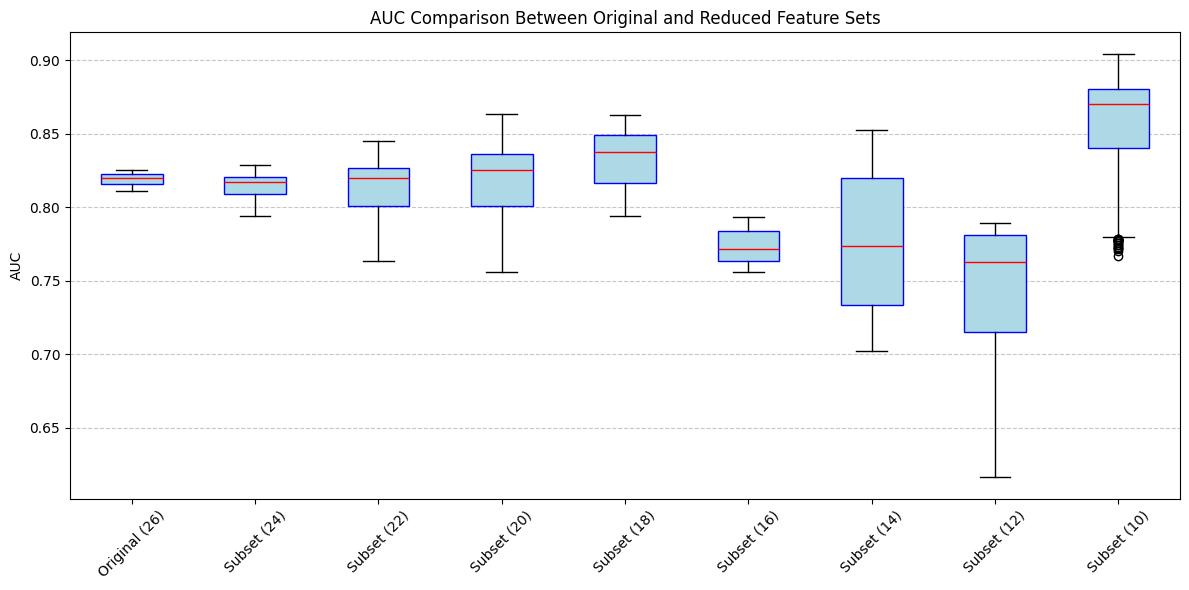

In [616]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 2. 원본 데이터셋(26개의 특성) 필터링
original_dataset = data[data['Num_Attributes'] == 26]

# 3. 하위 데이터셋 필터링 (특성이 24부터 10까지 줄어든 경우)
subset_datasets = {}
for num_attributes in range(24, 9, -2):  # 24, 22, ..., 10
    subset_datasets[num_attributes] = data[data['Num_Attributes'] == num_attributes]

# 4. AUC 값 추출
original_auc = original_dataset['AUC'].values
subset_aucs = {num_attributes: subset['AUC'].values for num_attributes, subset in subset_datasets.items()}

# 5. Wilcoxon signed-rank test 수행 (원본 vs 하위 데이터셋)
results = {}
for num_attributes, auc_values in subset_aucs.items():
    if len(original_auc) == len(auc_values):  # 두 샘플의 크기가 같아야 함
        stat, p_value = wilcoxon(original_auc, auc_values)
        results[num_attributes] = (stat, p_value)
    else:
        results[num_attributes] = ("N/A", "Sample size mismatch")

# 결과 출력
print("Wilcoxon Test Results:")
for num_attributes, (stat, p_value) in results.items():
    print(f"Original vs Subset ({num_attributes} attributes): Statistic={stat}, P-value={p_value}")

# 6. AUC 시각화 (Boxplot)
plt.figure(figsize=(12, 6))
labels = ['Original (26)'] + [f'Subset ({num})' for num in sorted(subset_aucs.keys(), reverse=True)]
auc_data = [original_auc] + [subset_aucs[num] for num in sorted(subset_aucs.keys(), reverse=True)]
plt.boxplot(auc_data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.title('AUC Comparison Between Original and Reduced Feature Sets')
plt.ylabel('AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wilcoxon Test Results (Weights_Column):
Original vs Majority_Voting: Statistic=6151.0, P-value=1.960600652434639e-06
Original vs Mean_Aggregation: Statistic=6601.0, P-value=2.57222900811701e-05
Original vs Median_Aggregation: Statistic=4075.0, P-value=3.0876820160327846e-13


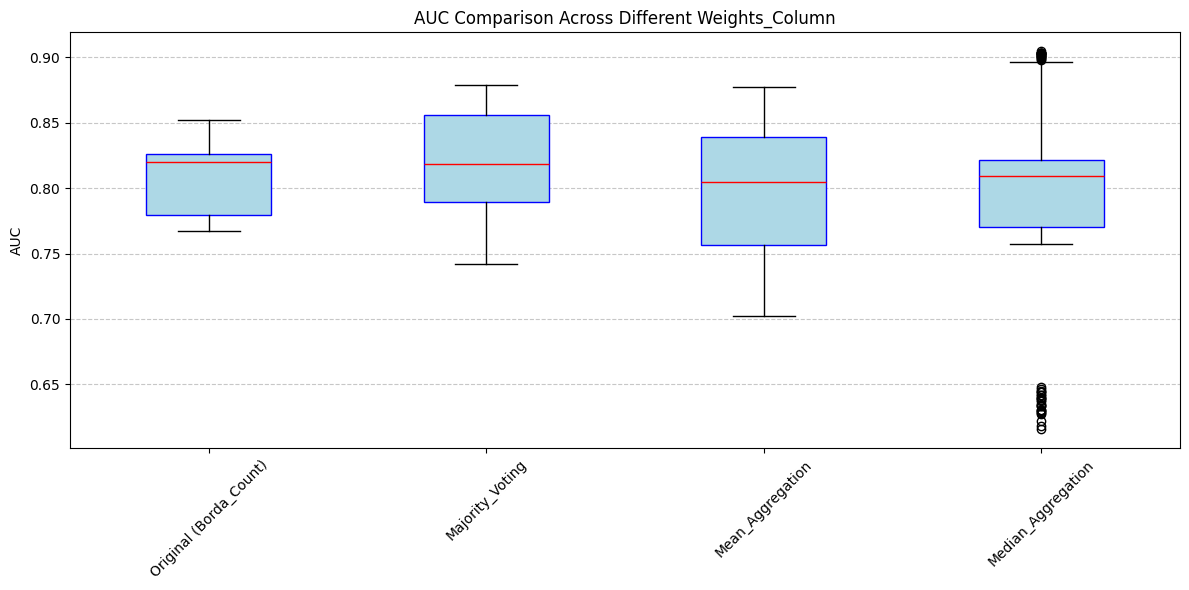

In [615]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 2. Weights_Column의 고유 값 추출
weights_columns = data['Weights_Column'].unique()

# 3. 각 Weights_Column 값에 따른 데이터셋 필터링
subset_datasets = {weight: data[data['Weights_Column'] == weight] for weight in weights_columns}

# 4. AUC 값 추출
original_auc = subset_datasets[weights_columns[0]]['AUC'].values  # 첫 번째 Weights_Column을 원본으로 설정
subset_aucs = {weight: subset['AUC'].values for weight, subset in subset_datasets.items() if weight != weights_columns[0]}

# 5. Wilcoxon signed-rank test 수행 (원본 vs 다른 Weights_Column)
results = {}
for weight, auc_values in subset_aucs.items():
    if len(original_auc) == len(auc_values):  # 두 샘플 크기가 같아야 함
        stat, p_value = wilcoxon(original_auc, auc_values)
        results[weight] = (stat, p_value)
    else:
        results[weight] = ("N/A", "Sample size mismatch")

# 결과 출력
print("Wilcoxon Test Results (Weights_Column):")
for weight, (stat, p_value) in results.items():
    print(f"Original vs {weight}: Statistic={stat}, P-value={p_value}")

# 6. Boxplot 시각화 (Weights_Column에 따른 AUC 분포 비교)
plt.figure(figsize=(12, 6))
labels = [f'Original ({weights_columns[0]})'] + [f'{weight}' for weight in subset_aucs.keys()]
auc_data = [original_auc] + [subset_aucs[weight] for weight in subset_aucs.keys()]
plt.boxplot(auc_data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.title('AUC Comparison Across Different Weights_Column')
plt.ylabel('AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wilcoxon Test Results (MROS_Percentage):
Original vs 0.2: Statistic=5666.0, P-value=0.00039824603843462874
Original vs 0.3: Statistic=3015.0, P-value=2.3328496206878735e-13
Original vs 0.4: Statistic=3208.0, P-value=1.7574614943351238e-12
Original vs 0.5: Statistic=3577.0, P-value=6.78324930037374e-11


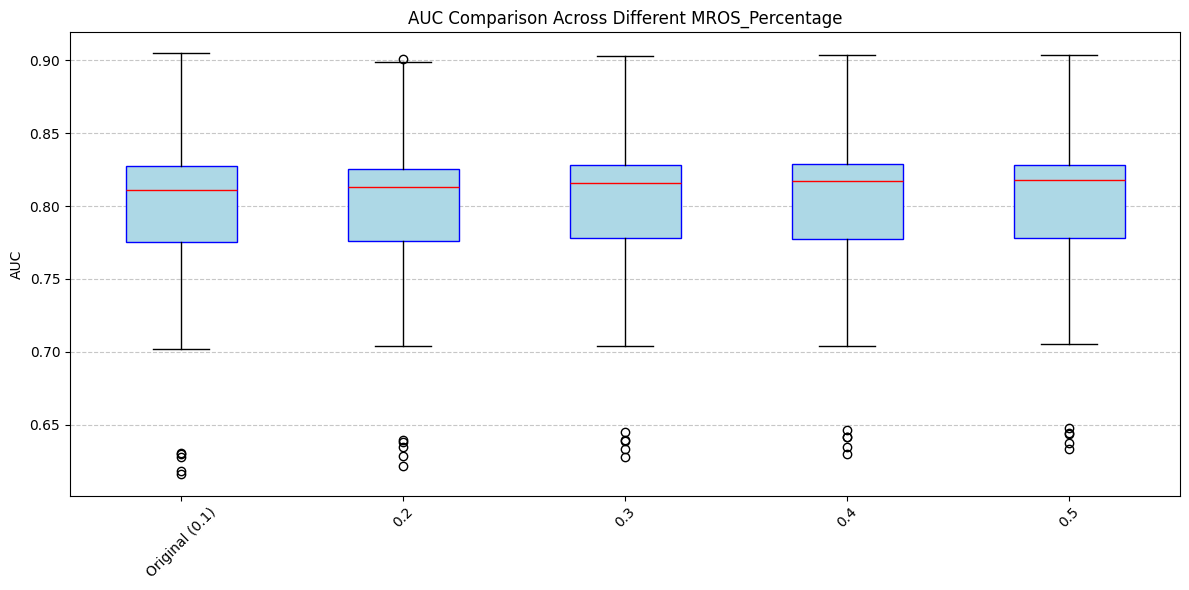

In [614]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 2. MROS_Percentage 고유 값 추출
weights_columns = data['MROS_Percentage'].unique()

# 3. 각 MROS_Percentage 값에 따른 데이터셋 필터링
subset_datasets = {weight: data[data['MROS_Percentage'] == weight] for weight in weights_columns}

# 4. AUC 값 추출
original_auc = subset_datasets[weights_columns[0]]['AUC'].values  # 첫 번째 MROS_Percentage 원본으로 설정
subset_aucs = {weight: subset['AUC'].values for weight, subset in subset_datasets.items() if weight != weights_columns[0]}

# 5. Wilcoxon signed-rank test 수행 (원본 vs 다른 MROS_Percentage)
results = {}
for weight, auc_values in subset_aucs.items():
    if len(original_auc) == len(auc_values):  # 두 샘플 크기가 같아야 함
        stat, p_value = wilcoxon(original_auc, auc_values)
        results[weight] = (stat, p_value)
    else:
        results[weight] = ("N/A", "Sample size mismatch")

# 결과 출력
print("Wilcoxon Test Results (MROS_Percentage):")
for weight, (stat, p_value) in results.items():
    print(f"Original vs {weight}: Statistic={stat}, P-value={p_value}")

# 6. Boxplot 시각화 (MROS_Percentage 따른 AUC 분포 비교)
plt.figure(figsize=(12, 6))
labels = [f'Original ({weights_columns[0]})'] + [f'{weight}' for weight in subset_aucs.keys()]
auc_data = [original_auc] + [subset_aucs[weight] for weight in subset_aucs.keys()]
plt.boxplot(auc_data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.title('AUC Comparison Across Different MROS_Percentage')
plt.ylabel('AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wilcoxon Test Results (Sampling_Fraction):
Original vs 0.2: Statistic=7164.0, P-value=0.16110785564696362
Original vs 0.3: Statistic=460.0, P-value=4.876136862014917e-28
Original vs 0.4: Statistic=464.0, P-value=5.194380726681617e-28
Original vs 0.5: Statistic=2387.0, P-value=1.9472865601607462e-16


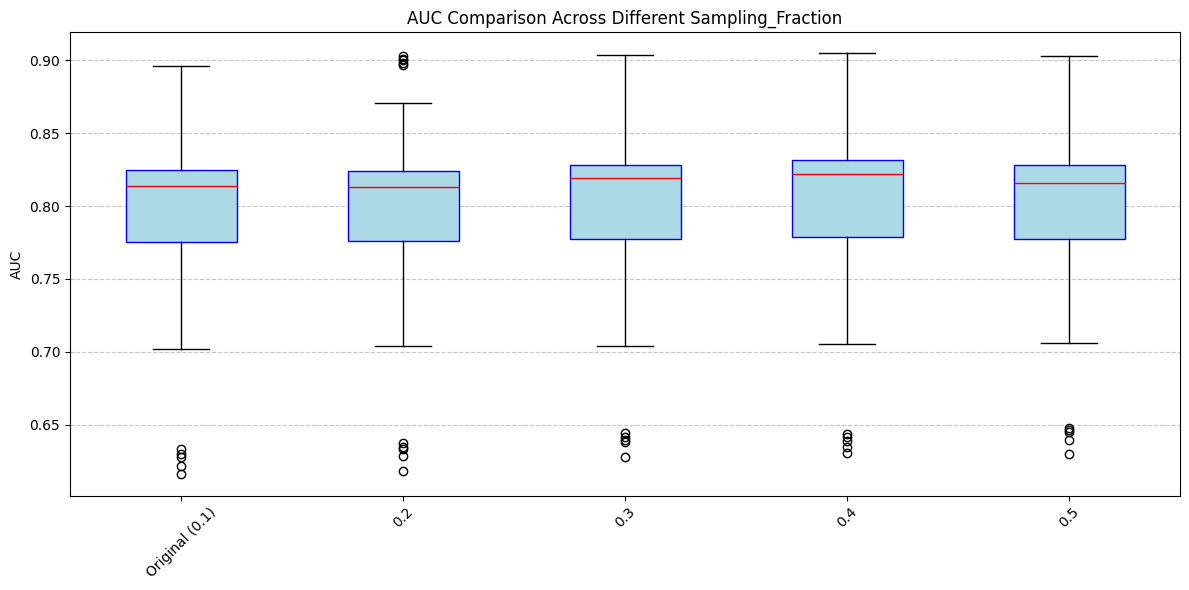

In [613]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 2. Sampling_Fraction 고유 값 추출
weights_columns = data['Sampling_Fraction'].unique()

# 3. 각 Sampling_Fraction 값에 따른 데이터셋 필터링
subset_datasets = {weight: data[data['Sampling_Fraction'] == weight] for weight in weights_columns}

# 4. AUC 값 추출
original_auc = subset_datasets[weights_columns[0]]['AUC'].values  # 첫 번째 Sampling_Fraction 원본으로 설정
subset_aucs = {weight: subset['AUC'].values for weight, subset in subset_datasets.items() if weight != weights_columns[0]}

# 5. Wilcoxon signed-rank test 수행 (원본 vs 다른 Sampling_Fraction)
results = {}
for weight, auc_values in subset_aucs.items():
    if len(original_auc) == len(auc_values):  # 두 샘플 크기가 같아야 함
        stat, p_value = wilcoxon(original_auc, auc_values)
        results[weight] = (stat, p_value)
    else:
        results[weight] = ("N/A", "Sample size mismatch")

# 결과 출력
print("Wilcoxon Test Results (Sampling_Fraction):")
for weight, (stat, p_value) in results.items():
    print(f"Original vs {weight}: Statistic={stat}, P-value={p_value}")

# 6. Boxplot 시각화 (Sampling_Fraction 따른 AUC 분포 비교)
plt.figure(figsize=(12, 6))
labels = [f'Original ({weights_columns[0]})'] + [f'{weight}' for weight in subset_aucs.keys()]
auc_data = [original_auc] + [subset_aucs[weight] for weight in subset_aucs.keys()]
plt.boxplot(auc_data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.title('AUC Comparison Across Different Sampling_Fraction')
plt.ylabel('AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_10908\1256933957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Weights_Column_Numeric'] = data_filtered['Weights_Column'].astype('category').cat.codes
C:\Users\user\AppData\Local\Temp\ipykernel_10908\1256933957.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


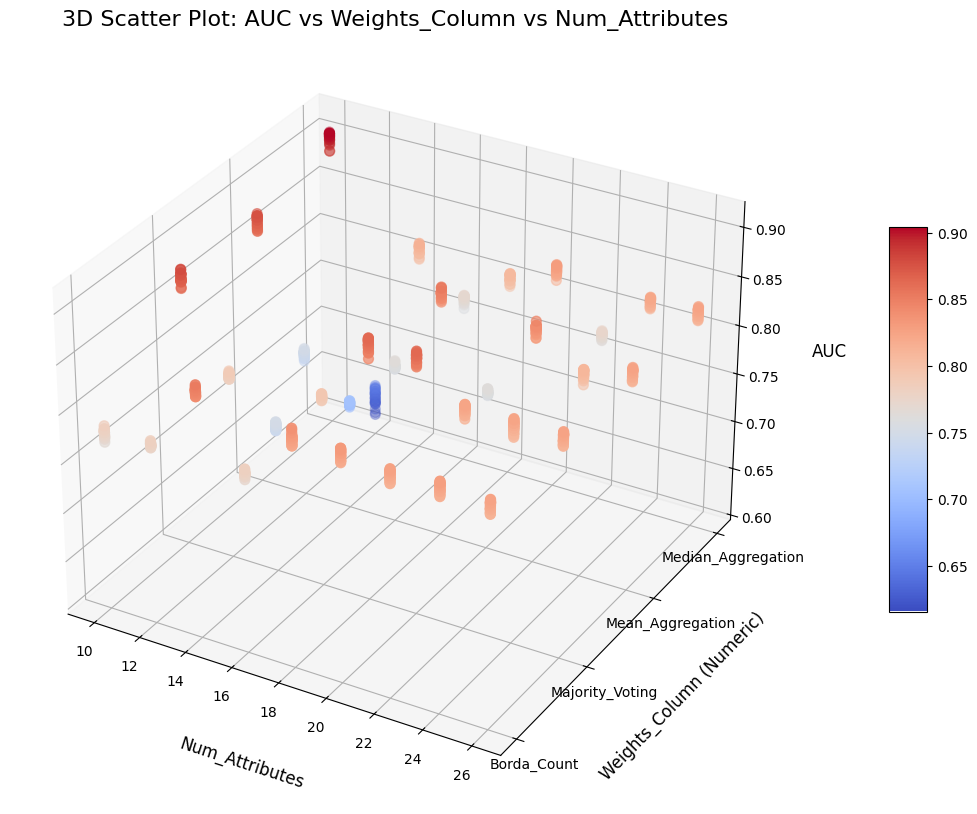

In [634]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
data = pd.read_csv(r"D:\Users\user\jupyter2\ml\dataset\User1\Final_Results_Summary.csv")

# 2. 필요한 컬럼 선택 (AUC, Weights_Column, Num_Attributes)
data_filtered = data[['AUC', 'Weights_Column', 'Num_Attributes']]

# 3. Weights_Column을 숫자로 변환 (3D 시각화를 위해)
data_filtered['Weights_Column_Numeric'] = data_filtered['Weights_Column'].astype('category').cat.codes

# 4. 3D Scatter Plot 생성
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# X, Y, Z 축 설정
x = data_filtered['Num_Attributes']
y = data_filtered['Weights_Column_Numeric']
z = data_filtered['AUC']

# Scatter Plot (색상을 붉은색~보라색 계열로 변경)
scatter = ax.scatter(x, y, z, c=z, cmap='coolwarm', s=50)

# 축 라벨 설정 (여백 추가)
ax.set_xlabel('Num_Attributes', fontsize=12, labelpad=20)
ax.set_ylabel('Weights_Column (Numeric)', fontsize=12, labelpad=20)
ax.set_zlabel('AUC', fontsize=12, labelpad=20)
ax.set_title('3D Scatter Plot: AUC vs Weights_Column vs Num_Attributes', fontsize=16)

# Weights_Column의 실제 이름 표시
weights_labels = dict(enumerate(data_filtered['Weights_Column'].astype('category').cat.categories))
ax.set_yticks(range(len(weights_labels)))
ax.set_yticklabels(weights_labels.values(), fontsize=10)

# 컬러바 추가
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('', fontsize=12)

# 그래프 여백 조정 및 시각적 개선
plt.tight_layout()
plt.show()
